## Aleatoric Uncertainty

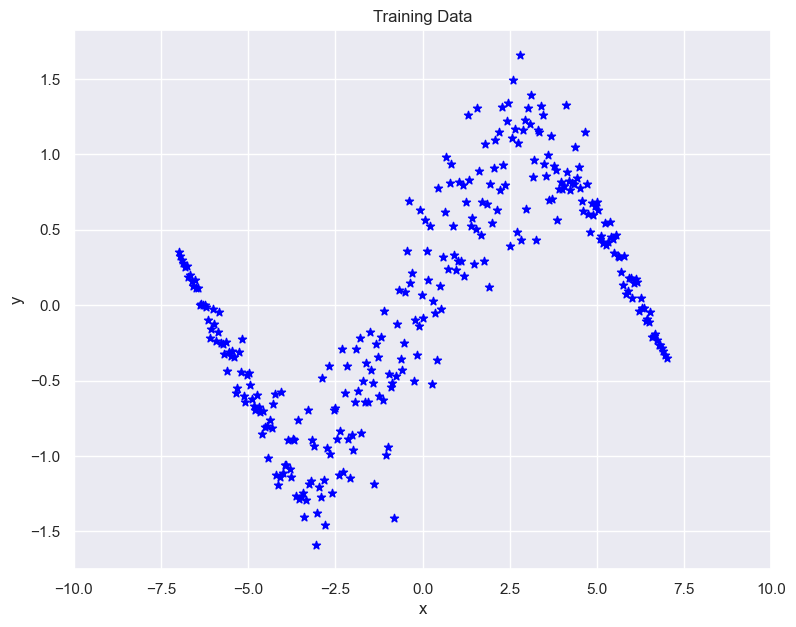

In [13]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
import math
import numpy as np
import seaborn as sns


sns.set(rc={'figure.figsize': (9, 7)})

def sample_dataset(start, end, n):
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]
    sample_var = [((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs()
    return x, y

start = -7
end = 7
n = 300

x_train, y_train = sample_dataset(start, end, n)
# scatter(x_train, y_train, c="blue", marker="*")

plt.scatter(x_train, y_train, c="blue", marker="*")
plt.xlim([-10, 10])
plt.title("Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Distribution for test dataset 

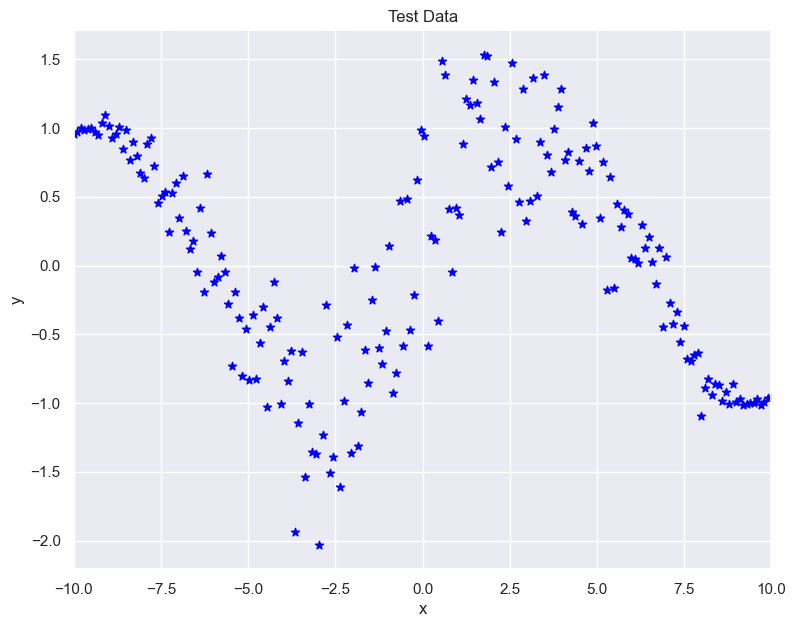

In [14]:
x_test, y_test = sample_dataset(-10, 10, 200)
# scatter(x_test, y_test, c="green", marker="*")

plt.scatter(x_test, y_test, c="blue", marker="*")
plt.xlim([-10, 10])
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [15]:
import tensorflow as tf
# Convert data to tensors
tensor_x_train = tf.convert_to_tensor(x_train.reshape(-1, 1), dtype=tf.float32)
tensor_y_train = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
tensor_x_test = tf.convert_to_tensor(x_test.reshape(-1, 1), dtype=tf.float32)

## Model for Maximum Likelihood Estimation 

In [21]:
# class SimpleNet(tf.keras.Model):
#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         hidden_size = 64
# 
#         # only 1 input feature for now
#         self.fc1 = tf.keras.layers.Dense(hidden_size)
#         self.fc2 = tf.keras.layers.Dense(hidden_size)
#         self.mu = tf.keras.layers.Dense(1)
#         self.var = tf.keras.layers.Dense(1)
# 
#     def call(self, x):
#         h = tf.math.tanh(self.fc1(x))
#         h = tf.math.tanh(self.fc2(h))
#         mu = self.mu(h)
#         # used Exponential activation for positive var
#         var = tf.math.exp(self.var(h))
#         return mu, var
#     
#     def make_aleatoric_plot(self,model, tensor_x_test, x_test, y_test, start=None, end=None):
#         # Get predictions
#         mu, var = model(tensor_x_test)
#         mu, sigma = mu.numpy(), var.numpy() ** 0.5
#     
#         # ~95% confidence interval
#         y_vals = [mu, mu + 2 * sigma, mu - 2 * sigma]
#         dfs = []
#     
#         # Create DataFrame from predictions
#         for i in range(3):
#             data = {
#                 "x": tensor_x_test.numpy().squeeze(),
#                 "y": y_vals[i].squeeze()
#             }
#             temp = pd.DataFrame(data)
#             dfs.append(temp)
#         df = pd.concat(dfs).reset_index(drop=True)
#     
#         # Plot predictions with confidence intervals
#         sns_plot = sns.lineplot(data=df, x="x", y="y")
#     
#         # Highlight training range (if provided)
#         if start is not None:
#             plt.axvline(x=start, color='red', linestyle='--')
#         if end is not None:
#             plt.axvline(x=end, color='red', linestyle='--')
#     
#         # Plot test data on top
#         plt.scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
#         plt.show()

In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

sns.set(rc={'figure.figsize': (9, 7)})

class AleatoricModel(tf.keras.Model):
    def __init__(self):
        super(AleatoricModel, self).__init__()
        hidden_size = 64

        # Define layers
        self.fc1 = tf.keras.layers.Dense(hidden_size)
        self.fc2 = tf.keras.layers.Dense(hidden_size)
        self.mu = tf.keras.layers.Dense(1)
        self.var = tf.keras.layers.Dense(1)
        
        # Placeholder for training data (optional)
        self.x_train = None
        self.y_train = None

    def call(self, x):
        h = tf.math.tanh(self.fc1(x))
        h = tf.math.tanh(self.fc2(h))
        mu = self.mu(h)
        var = tf.math.softplus(self.var(h))  # Ensure variance is positive
        return mu, var

    def nll_loss(self, y_true, y_pred_mu, y_pred_var):
        loss = 0.5 * tf.math.log(y_pred_var) + \
               0.5 * ((y_true - y_pred_mu) ** 2) / y_pred_var
        return tf.reduce_mean(loss)
    
    def train_model(self, x_train, y_train, epochs=1000, learning_rate=0.01):
        self.x_train = x_train
        self.y_train = y_train
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        # Build the model (if not already built)
        if not self.built:
            self.build(input_shape=x_train.shape)
        
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                mu, var = self(x_train)
                loss = self.nll_loss(y_train, mu, var)
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    def make_aleatoric_plot(self, x_test, y_test, start=None, end=None):
        # Get predictions
        mu, var = self(x_test)
        mu, sigma = mu.numpy(), var.numpy() ** 0.5

        # ~95% confidence interval
        y_vals = [mu.squeeze(), (mu + 2 * sigma).squeeze(), (mu - 2 * sigma).squeeze()]
        dfs = []

        # Create DataFrame from predictions
        for i in range(3):
            data = {
                "x": x_test.numpy().squeeze(),
                "y": y_vals[i]
            }
            temp = pd.DataFrame(data)
            dfs.append(temp)
        df = pd.concat(dfs).reset_index(drop=True)

        # Plot predictions with confidence intervals
        plt.figure(figsize=(9, 7))
        sns.lineplot(data=df, x="x", y="y")

        # Highlight training range (if provided)
        if start is not None:
            plt.axvline(x=start, color='red', linestyle='--', label='Training Range Start')
        if end is not None:
            plt.axvline(x=end, color='red', linestyle='--', label='Training Range End')

        # Plot test data and training data
        plt.scatter(x_test.numpy(), y_test, c="green", marker="*", alpha=0.3, label="Test Data")
        if self.x_train is not None and self.y_train is not None:
            plt.scatter(self.x_train.numpy(), self.y_train.numpy(), c="blue", marker="o", alpha=0.5, label="Train Data")
        plt.title("Model Predictions with Aleatoric Uncertainty")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

## Training and testing

In [25]:
import pandas as pd

# Instantiate the model
net = AleatoricModel()
print(net)
# print("Params:", net.count_params())
      
# Instantiate and train the model
model = AleatoricModel()
model.train_model(x_train, y_train, epochs=1000, learning_rate=0.01)
# 
# # Generate test data
# x_test_np = np.linspace(-10, 10, 400)
# sample_mean_test = np.sin(x_test_np / 2)
# max_variance_point = (abs(start) + abs(end)) / 2
# sample_var_test = (max_variance_point - np.abs(x_test_np)) / 16
# sample_var_test = np.clip(sample_var_test, a_min=0.01, a_max=None)
# y_test_np = stats.norm(sample_mean_test, sample_var_test).rvs()
# 
# # Convert test data to tensors
# x_test = tf.convert_to_tensor(x_test_np.reshape(-1, 1), dtype=tf.float32)
# 
# # Plot the results using the method in the class
# model.make_aleatoric_plot(x_test, y_test_np, start, end)



<AleatoricModel name=aleatoric_model_3, built=False>


C:\Users\Studium\Documents\uni\bachelorarbeit\uqX\.venv\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'aleatoric_model_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


ValueError: Exception encountered when calling AleatoricModel.call().

[1mInput 0 of layer "dense_38" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (300,)[0m

Arguments received by AleatoricModel.call():
  • x=tf.Tensor(shape=(300,), dtype=float32)

## making sure of dependency compatilibility (tf - tf.prob - tf.keras)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

print("TensorFlow version:", tf.__version__)  # Should print 2.17.0
print("TFP version:", tfp.__version__)        # Should print 0.24.0

# Test TF-Keras integration
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

print("Model initialized successfully.")

In [ ]:
import tensorflow as tf
from uqX.modeling.uqXModel import uqXModel

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_val = X_val.reshape(-1, 784) / 255.0

uq_model = uqXModel()
uq_model.plot_density_with_pca(X_train)

## testing out the BNN

In [ ]:
import tensorflow as tf
from uqX.modeling.uqXModel import uqXModel

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_val = X_val.reshape(-1, 784) / 255.0
data = (X_train, y_train, X_val, y_val)

uq_model = uqXModel()
uq_model.train_model(data, uq_method="bayes_by_backprop")

## testing out the MC Dropout

In [ ]:
import tensorflow as tf
from uqX.modeling.uqXModel import uqXModel

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_val = X_val.reshape(-1, 784) / 255.0

data = (X_train, y_train, X_val, y_val)

# Train the model with MC Dropout
uq_model = uqXModel()
uq_model.train_model(data, uq_method="mc_dropout")

# # Make predictions with uncertainty
# mean_pred, uncertainty = uq_model.predict_with_mc_dropout(X_val[:100])
# 
# # Print predictions and uncertainty for the first sample
# print("Mean Prediction:", mean_pred[0])
# print("Uncertainty:", uncertainty[0])